# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


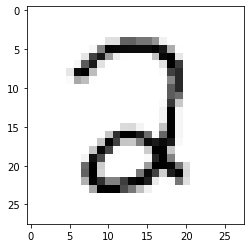

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2019
Training Accuracy: 0.8003, Testing Accuracy: 0.8185



Epoch 10, Loss 0.0635
Training Accuracy: 0.9336, Testing Accuracy: 0.9466



Epoch 20, Loss 0.0439
Training Accuracy: 0.9525, Testing Accuracy: 0.9607



Epoch 30, Loss 0.0366
Training Accuracy: 0.9596, Testing Accuracy: 0.9652



Epoch 40, Loss 0.0325
Training Accuracy: 0.9636, Testing Accuracy: 0.9672



Epoch 50, Loss 0.0298
Training Accuracy: 0.9661, Testing Accuracy: 0.9718



Epoch 60, Loss 0.0278
Training Accuracy: 0.9684, Testing Accuracy: 0.9723



Epoch 70, Loss 0.0263
Training Accuracy: 0.9700, Testing Accuracy: 0.9743



Epoch 80, Loss 0.0249
Training Accuracy: 0.9712, Testing Accuracy: 0.9753



Epoch 90, Loss 0.0238
Training Accuracy: 0.9716, Testing Accuracy: 0.9753



Epoch 100, Loss 0.0229
Training Accuracy: 0.9732, Testing Accuracy: 0.9758



Epoch 110, Loss 0.022
Training Accuracy: 0.9749, Testing Accuracy: 0.9768



Epoch 120, Loss 0.0212
Training Accuracy: 0.9758, Testing Accuracy: 0.9778



Epoch 130, Loss 0.0205
Training Accuracy: 0.9764, Testing Accuracy: 0.9773



Epoch 140, Loss 0.0198
Training Accuracy: 0.9777, Testing Accuracy: 0.9783



Epoch 150, Loss 0.0192
Training Accuracy: 0.9789, Testing Accuracy: 0.9783



Epoch 160, Loss 0.0186
Training Accuracy: 0.9798, Testing Accuracy: 0.9783



Epoch 170, Loss 0.018
Training Accuracy: 0.9810, Testing Accuracy: 0.9778



Epoch 180, Loss 0.0175
Training Accuracy: 0.9813, Testing Accuracy: 0.9778



Epoch 190, Loss 0.017
Training Accuracy: 0.9818, Testing Accuracy: 0.9768



Epoch 200, Loss 0.0165
Training Accuracy: 0.9825, Testing Accuracy: 0.9773



Epoch 210, Loss 0.0161
Training Accuracy: 0.9833, Testing Accuracy: 0.9783



Epoch 220, Loss 0.0157
Training Accuracy: 0.9839, Testing Accuracy: 0.9783



Epoch 230, Loss 0.0153
Training Accuracy: 0.9841, Testing Accuracy: 0.9778



Epoch 240, Loss 0.0148
Training Accuracy: 0.9846, Testing Accuracy: 0.9783



0.0028242844160057657

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2307
Training Accuracy: 0.7138, Testing Accuracy: 0.7006



Epoch 10, Loss 0.1047
Training Accuracy: 0.9021, Testing Accuracy: 0.9138



Epoch 20, Loss 0.0805
Training Accuracy: 0.9239, Testing Accuracy: 0.9370



Epoch 30, Loss 0.0693
Training Accuracy: 0.9351, Testing Accuracy: 0.9466



Epoch 40, Loss 0.0624
Training Accuracy: 0.9408, Testing Accuracy: 0.9526



Epoch 50, Loss 0.0578
Training Accuracy: 0.9451, Testing Accuracy: 0.9546



Epoch 60, Loss 0.0544
Training Accuracy: 0.9476, Testing Accuracy: 0.9572



Epoch 70, Loss 0.0518
Training Accuracy: 0.9488, Testing Accuracy: 0.9592



Epoch 80, Loss 0.0496
Training Accuracy: 0.9505, Testing Accuracy: 0.9607



Epoch 90, Loss 0.0479
Training Accuracy: 0.9521, Testing Accuracy: 0.9617



Epoch 100, Loss 0.0465
Training Accuracy: 0.9529, Testing Accuracy: 0.9617



Epoch 110, Loss 0.0452
Training Accuracy: 0.9536, Testing Accuracy: 0.9627



Epoch 120, Loss 0.0441
Training Accuracy: 0.9549, Testing Accuracy: 0.9642



Epoch 130, Loss 0.0432
Training Accuracy: 0.9558, Testing Accuracy: 0.9647



Epoch 140, Loss 0.0423
Training Accuracy: 0.9568, Testing Accuracy: 0.9642



Epoch 150, Loss 0.0416
Training Accuracy: 0.9572, Testing Accuracy: 0.9642



Epoch 160, Loss 0.0409
Training Accuracy: 0.9576, Testing Accuracy: 0.9647



Epoch 170, Loss 0.0403
Training Accuracy: 0.9579, Testing Accuracy: 0.9647



Epoch 180, Loss 0.0397
Training Accuracy: 0.9584, Testing Accuracy: 0.9657



Epoch 190, Loss 0.0392
Training Accuracy: 0.9590, Testing Accuracy: 0.9657



Epoch 200, Loss 0.0387
Training Accuracy: 0.9594, Testing Accuracy: 0.9657



Epoch 210, Loss 0.0382
Training Accuracy: 0.9599, Testing Accuracy: 0.9652



Epoch 220, Loss 0.0378
Training Accuracy: 0.9603, Testing Accuracy: 0.9652



Epoch 230, Loss 0.0374
Training Accuracy: 0.9607, Testing Accuracy: 0.9657



Epoch 240, Loss 0.037
Training Accuracy: 0.9614, Testing Accuracy: 0.9662



0.07607041791424565

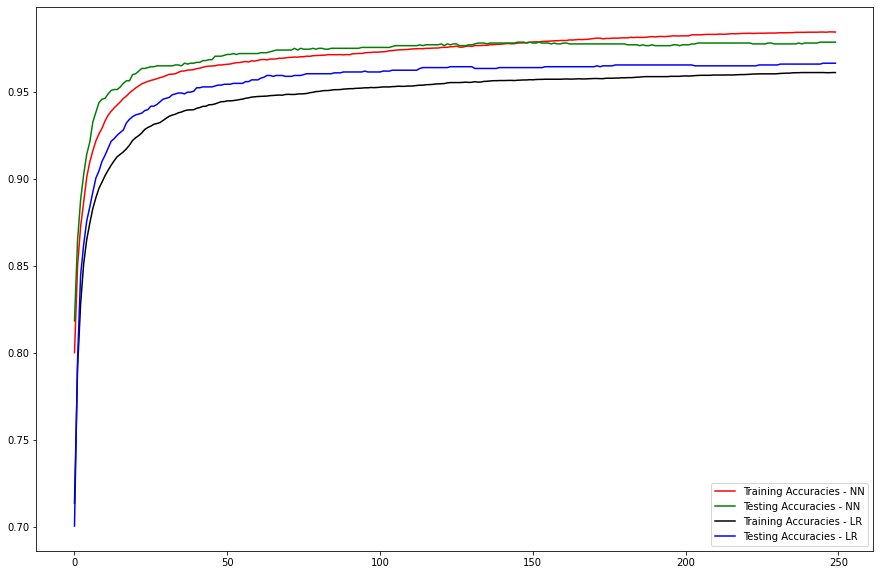

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

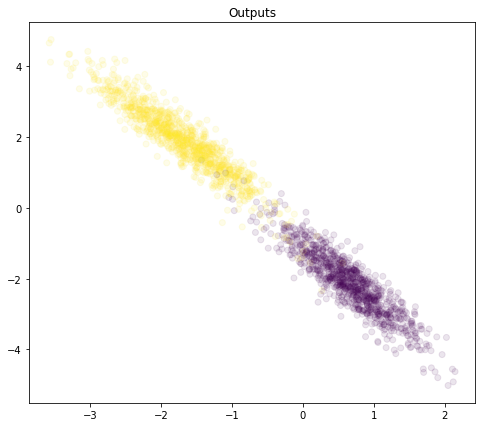

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

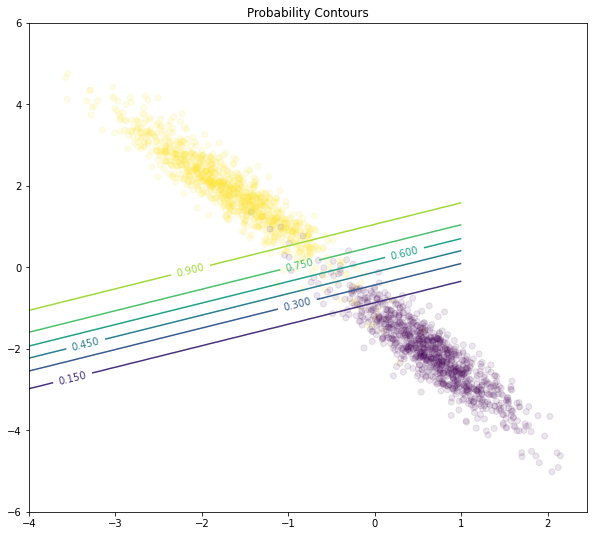

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );